### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
# sc.stop()

In [2]:
# sc.stop()
!pwd
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

/Users/Garrett/Documents/DSE/g4cheung_git/g4cheung/DSE230/Classes/2.PCA
Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12886
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TOBS|USC00058212|     2|[40 D6 28 D8 E0 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     3|[00 46 00 D3 00 7...|2000.0|SSSBBBBB|
+-

In [3]:
## vector is an array of 365 measurements in float16? yoav's code below unstacks it and turns it into a numpy array

In [4]:
## [north lat, south lat, east long, west long]
lat_long = [39.219785,39.177178,-106.801391,-106.872058]

df.filter(df.latitude < lat_long[0]).filter(df.latitude > lat_long[1]).filter(df.longitude < lat_long[2]).filter(df.longitude > lat_long[3]).show(10)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     0|[40 56 A0 56 90 5...|1981.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     3|[80 C9 00 00 80 D...|1982.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     3|[20 D0 80 C9 00 4...|1983.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     1|[80 C9 30 D4 00 D...|1984.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     2|[00 46 00 D3 00 D...|1985.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|    31|[00 7E 00 7E 00 7...|1986.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     0|[20 50 80 D1 80 4...|1987.0|SSSBBBBB|
|   2455.5

In [5]:
df.select('station').distinct().count()

221

In [6]:
df.select('elevation').sort('elevation', ascending=True).show(1)
df.select('elevation').sort('elevation', ascending=False).show(1)
df.select('latitude').sort('latitude', ascending=True).show(1)
df.select('latitude').sort('latitude', ascending=False).show(1)
df.select('longitude').sort('longitude', ascending=True).show(1)
df.select('longitude').sort('longitude', ascending=False).show(1)
df.select('year').sort('year',ascending=True).show(1)
df.select('year').sort('year',ascending=False).show(1)



# df.select('elevation','latitude','longitude').orderBy(['elevation','latitude','longitude'], ascending = [0]).show(1)
# df.orderBy(["age", "name"], ascending=[0, 1]).collect()
# df.select('name', 'age').collect()

+---------+
|elevation|
+---------+
|   1373.1|
+---------+
only showing top 1 row

+---------+
|elevation|
+---------+
|   3507.9|
+---------+
only showing top 1 row

+--------+
|latitude|
+--------+
| 39.1014|
+--------+
only showing top 1 row

+--------+
|latitude|
+--------+
| 39.8227|
+--------+
only showing top 1 row

+---------+
|longitude|
+---------+
|-108.7339|
+---------+
only showing top 1 row

+---------+
|longitude|
+---------+
|-105.1171|
+---------+
only showing top 1 row

+------+
|  year|
+------+
|1893.0|
+------+
only showing top 1 row

+------+
|  year|
+------+
|2012.0|
+------+
only showing top 1 row



we can see from our data: 

min elevation: 1373.1

max elevation: 3507.9

min latitude: 39.1014

max latitude: 39.8227

min longitude: -108.7339

max longitude: -105.1171

min year: 1893

max year: 2012

In [7]:
df.select('elevation').sort('elevation', ascending=True).take(1)[0]['elevation']

1373.1

In [8]:
df.select('elevation').sort('elevation', ascending=True).take(1)[0]#['elevation']

Row(elevation=1373.1)

In [9]:
datastats = {}
datastats['min_elev'] = df.select('elevation').sort('elevation', ascending=True).take(1)[0]['elevation']
datastats['max_elev'] = df.select('elevation').sort('elevation', ascending=False).take(1)[0]['elevation']
datastats['min_lat'] = df.select('latitude').sort('latitude', ascending=True).take(1)[0]['latitude']
datastats['max_lat'] = df.select('latitude').sort('latitude', ascending=False).take(1)[0]['latitude']
datastats['min_long'] = df.select('longitude').sort('longitude', ascending=True).take(1)[0]['longitude']
datastats['max_long'] = df.select('longitude').sort('longitude', ascending=False).take(1)[0]['longitude']
datastats['min_year'] = df.select('year').sort('year',ascending=True).take(1)[0]['year']
datastats['max_year'] = df.select('year').sort('year',ascending=False).take(1)[0]['year']
datastats

{'max_elev': 3507.9,
 'max_lat': 39.8227,
 'max_long': -105.1171,
 'max_year': 2012.0,
 'min_elev': 1373.1,
 'min_lat': 39.1014,
 'min_long': -108.7339,
 'min_year': 1893.0}

### Select data for a particular station and measurement type

In [10]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00050372')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(4)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00050372'
31 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     0|[40 56 A0 56 90 5...|1981.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     3|[80 C9 00 00 80 D...|1982.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     3|[20 D0 80 C9 00 4...|1983.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     1|[80 C9 30 D4 00 D...|1984.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 4 rows



(31, 365)

In [11]:
np.nanmean(T)
# T[0]

inf

### Script for plotting yearly plots

In [12]:
from YearPlotter import YearPlotter
# 39.535922 South Latitude: 39.513674 East Longitude: -105.290299 West Longitude: -105.321040
aspen_data = df.filter(df.latitude < lat_long[0]).filter(df.latitude > lat_long[1]).filter(df.longitude < lat_long[2]).filter(df.longitude > lat_long[3])
aspen_data.show(2)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     0|[40 56 A0 56 90 5...|1981.0|SSSBBBBB|
|   2455.5| 39.1853|-106.8381|       TMAX|USC00050372|     3|[80 C9 00 00 80 D...|1982.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



In [13]:
df1.filter(df1.latitude == 39.3333).filter(df1.longitude == -106.3333).show(5)

+---------+--------+---------+-----------+-------+------+------+----+-----+
|elevation|latitude|longitude|measurement|station|undefs|vector|year|label|
+---------+--------+---------+-----------+-------+------+------+----+-----+
+---------+--------+---------+-----------+-------+------+------+----+-----+



In [14]:
aspen_stations = aspen_data.select('station').distinct().collect()
aspen_stations[0][0]

u'USC00050372'

In [15]:

# for ii in ['TMAX']:#,'TMIN','TOBS']:#,'SNOW','SNWD','PRCP']: 
# #     fig_asp, ax_asp = plt.subplots(ncols=5,figsize=(7,5))
# ## snow, snwd, and prcp not included because those measure inches, not degrees
#     for kk in aspen_stations:
#         newdf = aspen_data.filter(aspen_data.measurement == ii).filter(aspen_data.station == kk[0])
#         yrs = newdf.select('year').distinct().collect()
#         for yr in yrs:
#             toplot = newdf.filter(newdf.year == yr[0])
#             rows=toplot.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
#             T=np.vstack(rows)
#             Temperature=T/10.*(9/5) + 32
#             fig_asp, ax_asp = plt.subplots(figsize=(10,7));
#             YP=YearPlotter()
#             YP.plot(Temperature[:1,:].transpose(),fig_asp,ax_asp,title=ii +' for '+ kk[0] + ' in ' + str(yr[0]))
#             plt.legend(['Temperature'], prop = {'size':10})
#             ax_asp.set_ylabel('Degrees Fahrenheit')
#             ax_asp.set_xlabel('Month')


In [16]:
def toPandas(self):

    return pd.DataFrame.from_records(self.collect(), columns=self.columns)

bokehtest = toPandas(aspen_data)

bokehtest = bokehtest.set_index('station')

bokehtest.head()

,elevation,latitude,longitude,measurement,undefs,vector,year,label
station,,,,,,,,
USC00050372,2455.5,39.1853,-106.8381,TMAX,0,"[64, 86, 160, 86, 144, 85, 224, 84, 144, 85, 1...",1981.0,SSSBBBBB
USC00050372,2455.5,39.1853,-106.8381,TMAX,3,"[128, 201, 0, 0, 128, 209, 224, 213, 64, 210, ...",1982.0,SSSBBBBB
USC00050372,2455.5,39.1853,-106.8381,TMAX,3,"[32, 208, 128, 201, 0, 79, 128, 77, 64, 76, 0,...",1983.0,SSSBBBBB
USC00050372,2455.5,39.1853,-106.8381,TMAX,1,"[128, 201, 48, 212, 0, 211, 128, 73, 48, 84, 0...",1984.0,SSSBBBBB
USC00050372,2455.5,39.1853,-106.8381,TMAX,2,"[0, 70, 0, 211, 0, 211, 128, 205, 128, 77, 128...",1985.0,SSSBBBBB


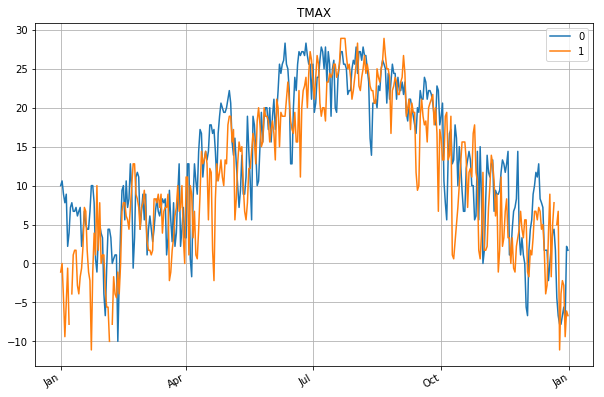

In [17]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX')
#title('A sample of graphs');

In [18]:
range(0,20,4)

[0, 4, 8, 12, 16]

In [19]:
int(ceil(datastats['min_elev']))

1374

In [20]:
### Plot elevation vs Temp
meantemps = []
elevs = range(int(floor((datastats['min_elev']))), int(ceil(datastats['max_elev'])), int(((datastats['max_elev']-datastats['min_elev'])/5)))
for ii in elevs:
    print(ii)
#     qq= "SELECT * FROM weather WHERE elevation > '%d' and elevation < '%d'"%(int(ii),int(ii)+500)
    df1 = df.filter(df.elevation <= ii+(int((datastats['max_elev']-datastats['min_elev'])/5))).filter(df.elevation >= ii).filter(df.measurement == 'TOBS')
#     df1.count()
#     df1 = sqlContext.sql(qq)
#     df1.count()
#     rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    try:
        rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
        T=np.vstack(rows)
        T=(T/10.*9/5)+32  # scaling to make the temperature be in fahrenheit
        meantemps.append(np.nanmean(T,dtype=float))
    except:
        elevs.remove(ii)
        break
#         df1.show(2)
#         print(rows)
#         print(T)
        T=(rows)
    

    
# plt.plot(elevs, meantemps)
    
    
    

# sqlContext.registerDataFrameAsTable(df,'weather')
# Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00058212')
# print Query
# df1 = sqlContext.sql(Query)
# print df1.count(),'rows'
# df1.show()
# rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
# T=np.vstack(rows)
# T=T/10.  # scaling to make the temperature be in centingrates
# shape(T)

1373
1799
2225
2651
3077
3503


In [21]:
elevs

[1373, 1799, 2225, 2651, 3077]

In [22]:
meantemps

[51.659217945088464,
 45.805987304289445,
 41.279129155856232,
 35.70971605860899,
 29.515493647091272]

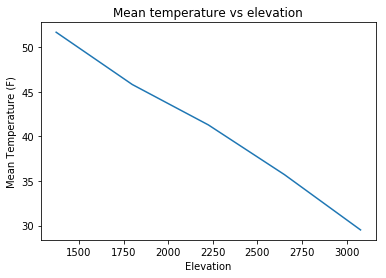

In [23]:
plot(elevs, meantemps)
plt.title('Mean temperature vs elevation')
plt.xlabel('Elevation')
plt.ylabel('Mean Temperature (F)')

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [24]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/Garrett/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


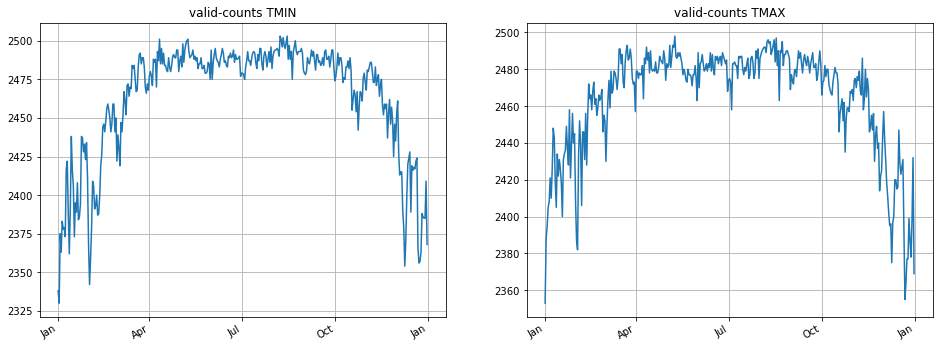

In [25]:
plot_pair(['TMIN','TMAX'],plot_valid)

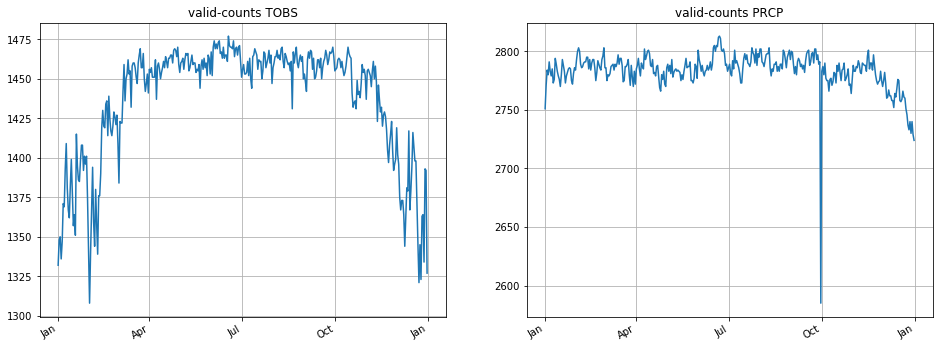

In [26]:
plot_pair(['TOBS','PRCP'],plot_valid)

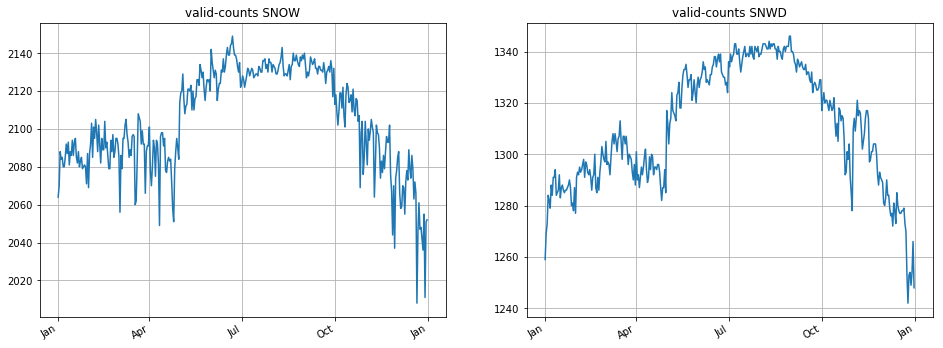

In [27]:
plot_pair(['SNOW', 'SNWD'],plot_valid)
##Snow depth is known as the measurement of snow that has fallen during previous weather events.

### Plots of mean and std of observations

In [28]:
print('Average precipitation = {}'.format(STAT['PRCP']['Mean'].mean()))

Average precipitation = 12.5355892632


In [29]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
#     print(mean, mean/10)
    
    std=np.sqrt(STAT[m]['Var'])
    if m in ['TMAX','TMIN','TOBS']:
        mean = mean/10
        std = std/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m, xlabel = 'Month',ylabel='Snowfall (mm)',labels=['Mean - Std','Mean','Mean + Std'])

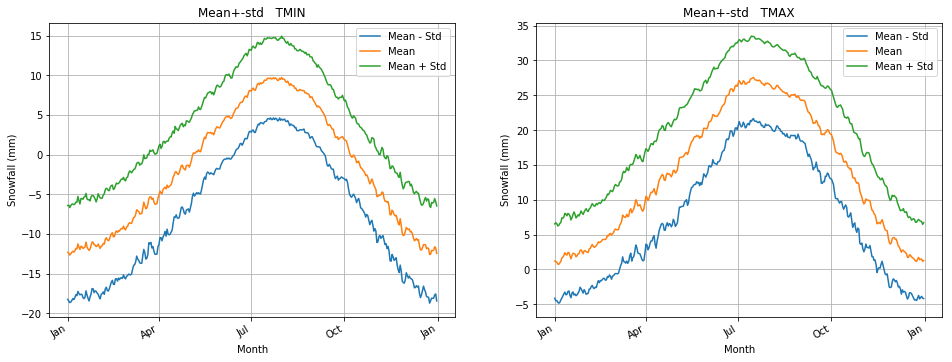

In [30]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

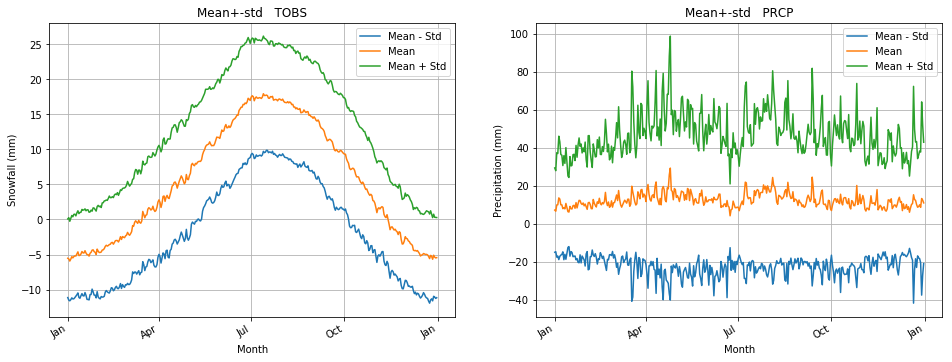

In [31]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
plt.ylabel('Precipitation (mm)')

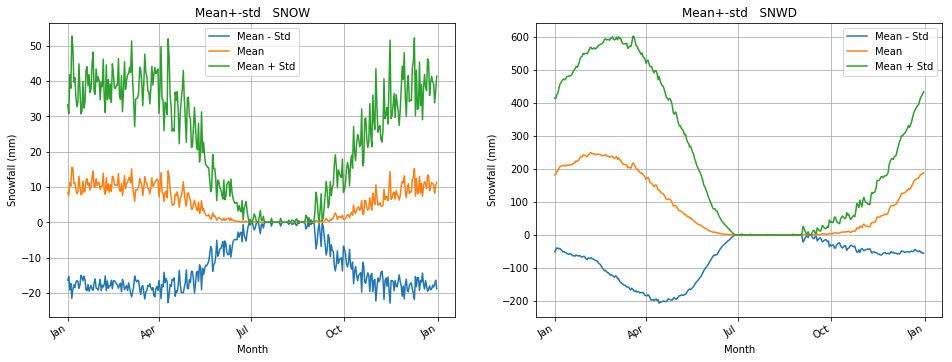

In [32]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [33]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m, labels = ['Eig 1','Eig 2','Eig 3'])

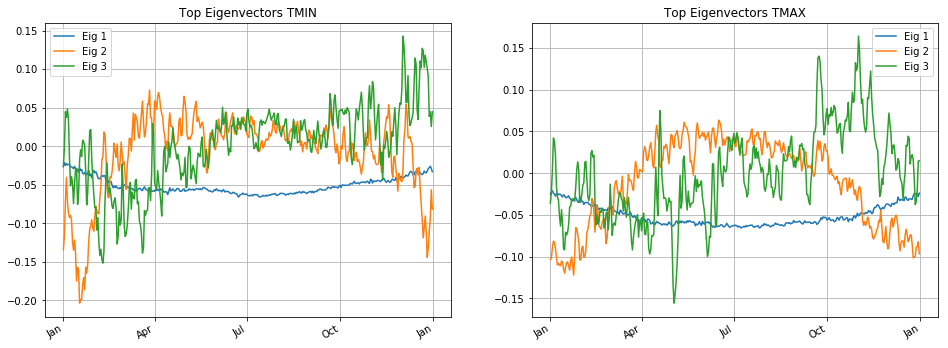

In [34]:
plot_pair(['TMIN','TMAX'],plot_eigen)

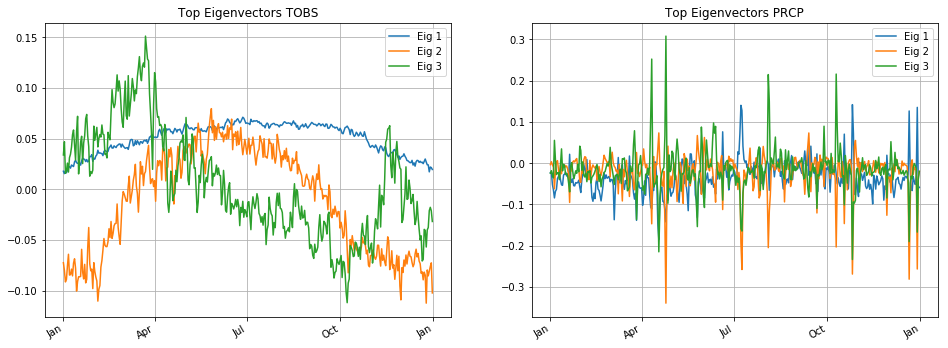

In [35]:
plot_pair(['TOBS','PRCP'],plot_eigen)

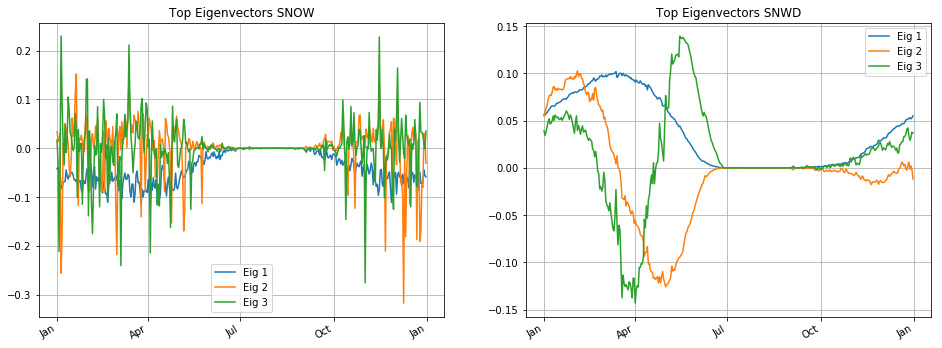

In [36]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [37]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

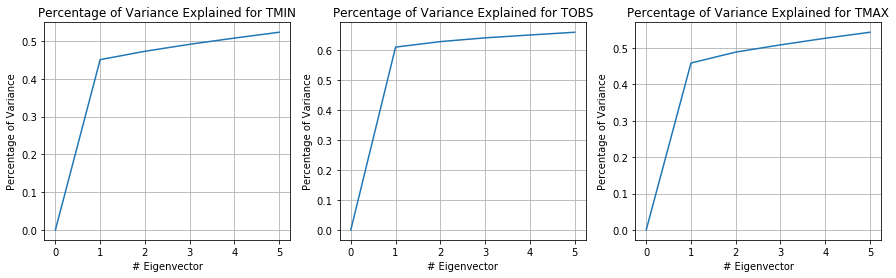

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

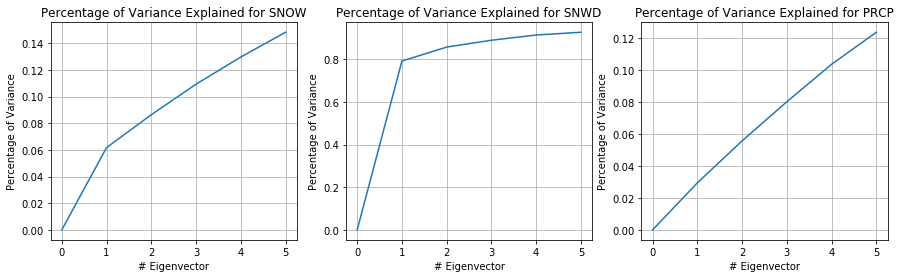

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [40]:
sc.stop()